# The Associated Press and Life Expectancy

**Story:** [AP analysis: Unemployment, income affect life expectancy](https://www.apnews.com/66ac44186b6249709501f07a7eab36da)

**Author:** Nicky Forster, Associated Press

**Topics:** Census Data, Linear Regression

**Datasets**

* **R12221544_SL140.csv:** ACS 2015 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table B23025: Employment Status
    - **R12221544.txt** is the data dictionary
* **R12221544_SL140.csv:** ACS 2015 5-year, tract level, from [Social Explorer](https://www.socialexplorer.com)
    - Table B23025: Employment Status
    - Table B06009: Educational Attainment
    - Table B03002: Race
    - Table B19013: Median income
    - Table C17002: Ratio of income to poverty level
    - **R12221544.txt** is the data dictionary
* **US_A.CSV:** life expectancy by census tract, from [USALEEP](https://www.cdc.gov/nchs/nvss/usaleep/usaleep.html)
    - **Record_Layout_CensusTract_Life_Expectancy.pdf** is data dictionary

We're trying to figure out how the **life expectancy in a census tract** is related to other factors like unemployment, income, and others.

## Reading in our data

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
life_exp_df=pd.read_csv("US_A.CSV")

In [3]:
life_exp_df=life_exp_df.rename(columns={
    "STATE2KX":"STATE_CODE",
    "CNTY2KX":"COUNTY_CODE",
    "Tract ID":"TRACT_ID",
    "e(0)": "LIFE_EXP",
    "se(e(0))":"STD_ERROR",
    "Abridged life table flag":"SOURCE"
})

In [4]:
life_exp_df.SOURCE=life_exp_df.SOURCE.replace({
    1: "Observed",
    2: "Predicted",
    3: "Both"
})

In [5]:
life_exp_df.SOURCE=life_exp_df.SOURCE.astype("category")

### Opening `R12221544_SL140.csv`


In [6]:
census_df=pd.read_csv("R12221544_SL140.csv", encoding="Latin-1")

In [7]:
census_df.columns

Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       'Geo_REGION', 'Geo_DIVISION', 'Geo_STATECE', 'Geo_STATE', 'Geo_COUNTY',
       'Geo_COUSUB', 'Geo_PLACE', 'Geo_PLACESE', 'Geo_TRACT', 'Geo_BLKGRP',
       'Geo_CONCIT', 'Geo_AIANHH', 'Geo_AIANHHFP', 'Geo_AIHHTLI', 'Geo_AITSCE',
       'Geo_AITS', 'Geo_ANRC', 'Geo_CBSA', 'Geo_CSA', 'Geo_METDIV', 'Geo_MACC',
       'Geo_MEMI', 'Geo_NECTA', 'Geo_CNECTA', 'Geo_NECTADIV', 'Geo_UA',
       'Geo_UACP', 'Geo_CDCURR', 'Geo_SLDU', 'Geo_SLDL', 'Geo_VTD',
       'Geo_ZCTA3', 'Geo_ZCTA5', 'Geo_SUBMCD', 'Geo_SDELM', 'Geo_SDSEC',
       'Geo_SDUNI', 'Geo_UR', 'Geo_PCI', 'Geo_TAZ', 'Geo_UGA', 'Geo_BTTR',
       'Geo_BTBG', 'Geo_PUMA5', 'Geo_PUMA1', 'ACS15_5yr_B23025001',
       'ACS15_5yr_B23025002', 'ACS15_5yr_B23025003', 'ACS15_5yr_B23025004',
       'ACS15_5yr_B23025005', 'ACS15_5yr_B23025006', 'ACS15_5yr_B23025007',
       'ACS15_5yr_B23025001s',

In [8]:
census_df.shape

(74001, 69)

In [9]:
census_df.sample(5)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,...,ACS15_5yr_B23025005,ACS15_5yr_B23025006,ACS15_5yr_B23025007,ACS15_5yr_B23025001s,ACS15_5yr_B23025002s,ACS15_5yr_B23025003s,ACS15_5yr_B23025004s,ACS15_5yr_B23025005s,ACS15_5yr_B23025006s,ACS15_5yr_B23025007s
26342,19179961000,14000US19179961000,"Census Tract 9610, Wapello County, Iowa","Census Tract 9610, Wapello County, Iowa",ia,140,0,ACSSF,5458,NaN,...,91,0,900,132.727273,115.757576,115.757576,113.333333,34.545455,5.454545,95.757576
26998,20173009503,14000US20173009503,"Census Tract 95.03, Sedgwick County, Kansas","Census Tract 95.03, Sedgwick County, Kansas",ks,140,0,ACSSF,4383,NaN,...,223,12,2327,206.666667,207.878788,207.272727,229.696970,66.060606,12.121212,169.090909
14279,12009066800,14000US12009066800,"Census Tract 668, Brevard County, Florida","Census Tract 668, Brevard County, Florida",fl,140,0,ACSSF,2066,NaN,...,22,68,352,69.696970,70.303030,70.909091,66.666667,13.333333,15.757576,41.818182
42076,34025810402,14000US34025810402,"Census Tract 8104.02, Monmouth County, New Jersey","Census Tract 8104.02, Monmouth County, New Jersey",nj,140,0,ACSSF,2788,NaN,...,261,0,2341,201.212121,220.000000,220.000000,216.363636,69.090909,10.303030,157.575758
36041,27053026509,14000US27053026509,"Census Tract 265.09, Hennepin County, Minnesota","Census Tract 265.09, Hennepin County, Minnesota",mn,140,0,ACSSF,6225,NaN,...,47,0,894,113.333333,121.818182,121.818182,117.575758,22.424242,5.454545,81.212121


#### Filtering out any columns we aren't interested in

In [10]:
#Retaining variables that I think should be in the model:

census_df=census_df[["Geo_FIPS","ACS15_5yr_B23025001", "ACS15_5yr_B23025002","ACS15_5yr_B23025003","ACS15_5yr_B23025004","ACS15_5yr_B23025005","ACS15_5yr_B23025006","ACS15_5yr_B23025007"]]

#### Creating a new column for percent unemployment

We'll be using the total population in the census tract as the baseline for employment.

In [11]:
census_df=census_df.rename(columns={
    "ACS15_5yr_B23025001": "total_pop",
    "ACS15_5yr_B23025002": "labor_force",      
    "ACS15_5yr_B23025003": "labor_force_civilian", 
    "ACS15_5yr_B23025004": "civilian_employed",
    "ACS15_5yr_B23025005": "civilian_unemployed",
    "ACS15_5yr_B23025006": "labor_force_armed",
    "ACS15_5yr_B23025007": "not_labor_force",
    "Geo_FIPS":"TRACT_ID"
})


In [12]:
census_df["pct_employed"]=((census_df["civilian_employed"]+census_df["labor_force_armed"])/census_df["total_pop"])*100

In [13]:
merged_df=pd.merge(life_exp_df,census_df, on="TRACT_ID")

In [14]:
merged_df.sample(5)

,TRACT_ID,STATE_CODE,COUNTY_CODE,TRACT2KX,LIFE_EXP,STD_ERROR,SOURCE,total_pop,labor_force,labor_force_civilian,civilian_employed,civilian_unemployed,labor_force_armed,not_labor_force,pct_employed
31672,26161410400,26,161,410400,81.7,1.7717,Both,3331,2235,2235,1895,340,0,1096,56.889823
60792,48441013500,48,441,13500,81.6,1.5479,Both,6026,3887,3821,3565,256,66,2139,60.255559
59495,48217960400,48,217,960400,71.7,2.2472,Both,1395,699,699,606,93,0,696,43.440860
18249,13245010711,13,245,10711,72.8,1.6098,Both,2364,1378,1372,1211,161,6,986,51.480541
27731,24031701410,24,31,701410,80.4,2.7222,Predicted,5862,4869,4869,4336,533,0,993,73.967929


## Running the regression

Using the `statsmodels` package, running a linear regression to find the coefficient relating unemployment and life expectancy.

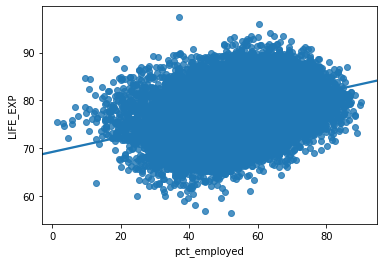

In [15]:
sns.regplot(x="pct_employed",y="LIFE_EXP", data=merged_df)

In [16]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [17]:
x=merged_df["pct_employed"]
x=sm.add_constant(x)
y=merged_df["LIFE_EXP"]

C:\Users\Anuja\AppData\Local\Programs\Python\Python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [18]:
model=sm.OLS(y,x)
result=model.fit()

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               LIFE_EXP   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                 1.188e+04
Date:                Mon, 22 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:44:27   Log-Likelihood:            -1.7872e+05
No. Observations:               65662   AIC:                         3.575e+05
Df Residuals:                   65660   BIC:                         3.575e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           69.1839      0.085    815.748      0.000      69.018      69.350
pct_employed     0.1579      0.001    109.012      0.000       0.155       0.161
==============================================================================
Omnibus:                      532.139   Durbin-Watson:                   1.168
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              784.798
Skew:                           0.082   Prob(JB):                    3.83e-171
Kurtosis:                       3.510   Cond. No.                         346.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# Adding the predicted y-values and residuals to the dataframe
merged_df["y_predicted"]=result.predict().reshape(-1,1)
merged_df["residuals"]=result.resid

In [21]:
# Creating a residual plot to look at the distribution of residuals (overestomation vs underestimation scatter)

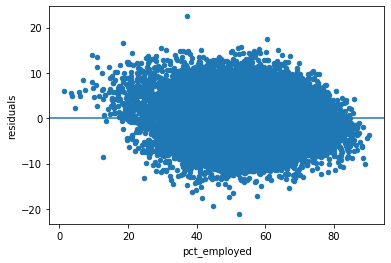

In [22]:
ax=merged_df.plot(x="pct_employed",y="residuals", kind="scatter")
ax.axhline(y=0)

#The plot is denser below 0, indicating that the model is underestimating y-values.

In [23]:
# Calculating the RMSE

#RMSE=sqrt(sum(residual**2)/n-1) OR sqrt(mse)
import numpy as np
rmse=np.sqrt(result.mse_resid)
print(rmse)


3.6801944459090876


In [24]:
# Calculating the average distance from the actual value for every point - residual/rmse
merged_df["pt_rmse"]=merged_df["residuals"]/rmse
merged_df.sample()

,TRACT_ID,STATE_CODE,COUNTY_CODE,TRACT2KX,LIFE_EXP,STD_ERROR,SOURCE,total_pop,labor_force,labor_force_civilian,civilian_employed,civilian_unemployed,labor_force_armed,not_labor_force,pct_employed,y_predicted,residuals,pt_rmse
54133,45013000700,45,13,700,74.6,1.1775,Both,4629,2779,2770,2655,115,9,1850,57.550227,78.272258,-3.672258,-0.997843


In [25]:
## Interpreting the results from the linear equation
# 1. The equation for the regression is: y=0.1579x+69.1839. 
#    For every unit increase in x (employment pct), there is a 0.1579 unit increase in y (Life expectancy)

# 2. Errors and residuals:
#    - Rsquared=0.153 or 15.3%: The r-square value is low - it indicates that only 15.3% of the variation in y is a result of x.
#    - Root Mean Square Error: +/- 3.68 - on average, life expectancy predicted by the line is +/-3.68 years away from the actual life expectancy.

## Bringing more columns into the mix

### Read in `R12221544_SL140.csv`

In [26]:
census_df2=pd.read_csv("R12221550_SL140.csv", encoding="Latin 1")

In [27]:
census_df2.columns

Index(['Geo_FIPS', 'Geo_GEOID', 'Geo_NAME', 'Geo_QName', 'Geo_STUSAB',
       'Geo_SUMLEV', 'Geo_GEOCOMP', 'Geo_FILEID', 'Geo_LOGRECNO', 'Geo_US',
       ...
       'ACS15_5yr_B23025005', 'ACS15_5yr_B23025006', 'ACS15_5yr_B23025007',
       'ACS15_5yr_B23025001s', 'ACS15_5yr_B23025002s', 'ACS15_5yr_B23025003s',
       'ACS15_5yr_B23025004s', 'ACS15_5yr_B23025005s', 'ACS15_5yr_B23025006s',
       'ACS15_5yr_B23025007s'],
      dtype='object', length=189)

In [28]:
census_df2.head(1)

,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,...,ACS15_5yr_B23025005,ACS15_5yr_B23025006,ACS15_5yr_B23025007,ACS15_5yr_B23025001s,ACS15_5yr_B23025002s,ACS15_5yr_B23025003s,ACS15_5yr_B23025004s,ACS15_5yr_B23025005s,ACS15_5yr_B23025006s,ACS15_5yr_B23025007s
0,1001020100,14000US01001020100,"Census Tract 201, Autauga County, Alabama","Census Tract 201, Autauga County, Alabama",al,140,0,ACSSF,1760,NaN,...,54,0,557,92.121212,85.454545,85.454545,83.636364,18.787879,6.666667,67.878788


In [29]:
#Note: Race has two broad categories - Latino/Hispanic and non-Latino/Hispanic whereas the instructions ask for percent black & 
## percent white. I have chosen to use percent hispanic and percent not hispanic, as hispanic, black and white are not mutually 
## exclusive categories (Hispanics can be white or black)

census_df2["percent_hispanic"]=(census_df2["ACS15_5yr_B03002012"]/census_df2["ACS15_5yr_B03002001"])*100
census_df2["percent_not_hispanic"]=(census_df2["ACS15_5yr_B03002002"]/census_df2["ACS15_5yr_B03002001"])*100

census_df2["percent_less_than_highschool"]=(census_df2["ACS15_5yr_B06009002"]/census_df2["ACS15_5yr_B06009001"])*100   
census_df2["percent_poverty_1.5"]=((census_df2["ACS15_5yr_C17002004"]+census_df2["ACS15_5yr_C17002005"])/census_df2["ACS15_5yr_C17002001"])*100        


In [30]:
census_df2=census_df2[["Geo_FIPS","percent_hispanic","percent_not_hispanic","percent_less_than_highschool","percent_poverty_1.5","ACS15_5yr_B19013001"]]

In [31]:
census_df2=census_df2.rename(columns={
    "Geo_FIPS":"TRACT_ID",
    "ACS15_5yr_B19013001":"Med_income"
})

### Joining our datasets

Combining our life expectancy dataset with this census dataset to create a new dataframe.

In [32]:
merged_df=census_df2.merge(merged_df, on="TRACT_ID")

In [38]:
merged_df=merged_df.drop(columns=["STATE_CODE","COUNTY_CODE","TRACT2KX","STD_ERROR","SOURCE","total_pop","labor_force", "labor_force_civilian","civilian_employed", "civilian_unemployed", "labor_force_armed","not_labor_force","y_predicted","residuals","pt_rmse"])

In [40]:
merged_df.dropna(inplace=True)

## Running a multivariate regression

Using the `statsmodels` package and this new dataframe, run a multivariate linear regression to find the coefficient relating your columns and life expectancy.

In [87]:
# x_vars=sm.add_constant(x_vars)
y_var=merged_df[["LIFE_EXP"]]
x_var1=merged_df[["percent_hispanic", "percent_less_than_highschool", "Med_income","percent_poverty_1.5"]]
model=sm.OLS(y_var,x_var1)
result=model.fit()

In [88]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               LIFE_EXP   R-squared (uncentered):                   0.960
Model:                            OLS   Adj. R-squared (uncentered):              0.960
Method:                 Least Squares   F-statistic:                          3.918e+05
Date:                Mon, 22 Jul 2019   Prob (F-statistic):                        0.00
Time:                        22:28:58   Log-Likelihood:                     -2.7404e+05
No. Observations:               65656   AIC:                                  5.481e+05
Df Residuals:                   65652   BIC:                                  5.481e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
percent_hispanic                -0.1806      0.004    -47.761      0.000      -0.188      -0.173
percent_less_than_highschool     0.7728      0.009     88.297      0.000       0.756       0.790
Med_income                       0.0008   1.21e-06    637.657      0.000       0.001       0.001
percent_poverty_1.5              2.2752      0.012    192.790      0.000       2.252       2.298
==============================================================================
Omnibus:                    17681.474   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70409.777
Skew:                          -1.293   Prob(JB):                         0.00
Kurtosis:                       7.364   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# ## Results:
# 1. For every unit increase in the hispanic population share, there is a -0.1806 of a year decrease in Life Expectancy.
# 2. For every unit increase in the population that has a lower level of education, there is a 0.7728 of a year increase in Life Expectancy.
# 3. For every unit increase in income, there is a 0.0008 of a year increase in Life Exp.
# 4. For every unit increase in people in the poverty range 1-1.5, there is a 2.2752 of a year increase in Life Expectancy.